In [113]:
import importlib

import mysklearn.mypytable as mypytable
import mysklearn.myutils as myutils
import mysklearn.myevaluation as myevaluation
import mysklearn.myclassifiers as myclassifiers
from tabulate import tabulate

importlib.reload(myutils)
importlib.reload(mypytable)
importlib.reload(myevaluation)
importlib.reload(myclassifiers)

<module 'mysklearn.myclassifiers' from '/home/CPSC322-Final-Project/mysklearn/myclassifiers.py'>

# **NBA Ratings Classifier EDA**

In this EDA we will be looking at a datasets which contains instances of NBA players with their stats and NBA 2K (videogame) ratings


We will use the attributes of this dataset to classify instances by their card type
>In NBA 2K, each player is given a card of a two general types based directly on their rating
>* If a player has a rating of 79 and below they are given a **basic** card represented by a Gold, Silver, or Bronze theme
>* If a player has a rating 80 or above they are given a **special** card represented by a Emerald, Sapphire, Ruby, Amythest, and Diamond themes

><img src="images/goldcard.png" width="200"> <img src="images/drose.png" width="200"> <img src="images/chrisPaul.png" width="200"><br>
>* The first card above is an example of a **basic** card (79 rated "gold")<br>
>* The following two cards are both **special** cards (80 rated "emerald" and 92 rated "amythest")   

## Data Preperation
### Dataset: nba_ratings.csv (https://www.kaggle.com/datasets/willyiamyu/nba-2k-ratings-with-real-nba-stats?select=nba_rankings_2014-2020.csv)
> We will immediately remote several attributes from the dataset that will are either too specific (ex. player name, team name, season) 
or redundant (ex. offensive rebounds, defensive rebounds, 3pt attempts, FG attempts)

>Also, to create a more equal distribution of class labels, we are are only interested in the basic type cards that are over 74 rated. All players with ratings less than 75 will be removed 

> The dataset that we will be using will consist of the attributes below. We will derive all subsets of data from this dataset.
* AGE (Age)
* MIN (minutes played)
* W% (W / GP)
* PTS (points per game)
* FG % (field goal percentage)
* 3PM (3 pt attemps)
* FT% (free throw percentage)
* REB (rebounds)

> These attributes will be used to classify the "ranking" (NBA 2K Ratings) of each instance (player)


In [114]:
import numpy as np


## load data into a MyPyTable
nba_data = mypytable.MyPyTable()
nba_data.load_from_file("nba_ratings.csv")
before_len = len(nba_data.data)

# clean table by removing players with 0% 3 point percentage or FG percentage or below 73 rated

rows_to_drop = []
for i, row in enumerate(nba_data.data):
  if nba_data.data[i][-1] < 76:
    rows_to_drop.append(i)
nba_data.drop_rows(rows_to_drop)

nba_data.drop_rows_with_zero_in_col(["3P%", "FG%"])
after_len = len(nba_data.data)
print(before_len - after_len, "/", before_len, "rows were removed during cleaning")


# get player names col as keys for the instances
#player_names = nba_data.pop_column("PLAYER") 


## TODO create a plot for distribution
# get ratings col (y) 
ratings = nba_data.get_column("rankings")
ratings = [myutils.ratings_discretizer(x) for x in ratings]

nba_data = nba_data.get_subtable(["PLAYER", "AGE", "MIN", "W", "GP", "PTS", "FG%", "3PM", "FT%", "REB"])

# change GP and W attributes to W% (win percentage) 
gp = nba_data.pop_column("GP")

win_index = nba_data.column_names.index("W")
nba_data.column_names[win_index] = "W%"

for i, row in enumerate(nba_data.data):
  nba_data.data[i][win_index] = round(nba_data.data[i][win_index] / gp[i], 2)



nba_data.discretize_col(["AGE"], myutils.age_discretizer)
nba_data.discretize_col(["FT%"], myutils.free_throw_discretizer)
nba_data.discretize_col(["MIN"], myutils.mins_played_discretizer)
nba_data.discretize_col(["PTS"], myutils.pts_discretizer)
nba_data.discretize_col(["3PM"], myutils.threePTRS_made_discretizer)
nba_data.discretize_col(["REB"], myutils.reb_discretizer)
nba_data.discretize_col(["FG%"], myutils.fg_discretizer)
nba_data.discretize_col(["W%"], myutils.win_percent_discretizer)

nba_data.column_names.append("card type")
nba_data.data = [nba_data.data[i] + [ratings[i]] for i in range(len(ratings)) ] 




sample_table = []
for i in range(10):
  sample_table.append(nba_data.data[np.random.randint(0, len(nba_data.data))])

sample_table = mypytable.MyPyTable(nba_data.column_names, sample_table)
print("Sample instances of discretized data")
sample_table.print_data()

# card_types = nba_data.pop_column("card type")


1482 / 2412 rows were removed during cleaning
Sample instances of discretized data
PLAYER            AGE    MIN       W%       PTS     FG%          3PM          FT%     REB             card type
----------------  -----  --------  -------  ------  -----------  -----------  ------  --------------  -----------
Marc Gasol        old    moderate  high     bottom  inefficient  low volume   poor    average volume  basic
JR Smith          old    moderate  average  mid     inefficient  high volume  poor    low volume      basic
Tim Hardaway Jr.  young  moderate  average  mid     inefficient  high volume  decent  low volume      basic
DeMarcus Cousins  young  high      low      top     efficient    low volume   decent  high volume     special
Mo Bamba          young  low       low      bottom  efficient    low volume   poor    average volume  basic
Rudy Gay          old    moderate  low      mid     efficient    low volume   decent  average volume  special
DeMarcus Cousins  young  moderate  high

# **Visual Representation of Dataset**

### Distribution of Class labels (special and basic)

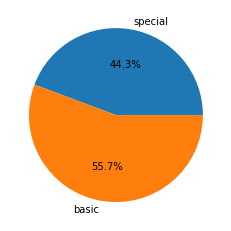

In [115]:
from mysklearn import Plot_Utils

special = 0
basic = 0
for rating in ratings:
  if rating == "special":
    special += 1
  else:
    basic += 1

Plot_Utils.create_pie_chart([special, basic], ["special", "basic"])



## Minutes Played

In the NBA, all of the best players play a high amount of minutes. Therefore, I believe this attribute is going to be one of the stronger attributes in terms of helping predict the card type of a player correctly.<br><br>

Here is a bar chart showing the distrubtion of players in the data set based on there minutes played each game

We almost have an even distribution of class labels (there are slightly more players with a basic card than a special card)

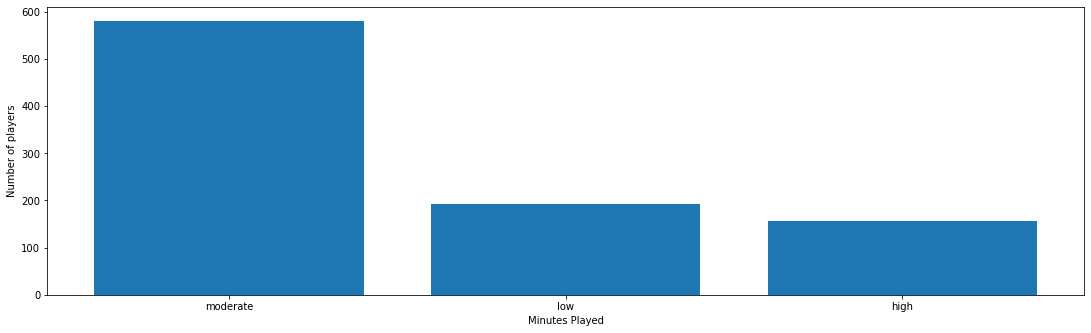

In [116]:
mins = nba_data.get_column("MIN")
Plot_Utils.create_bar_chart(mins, X_label="Minutes Played", Y_label="Number of players")

As you can see from this bar chart most of the players in the dataset fall under the moderate minutes group. <br>Only a small percent of players play high minutes (>34 minutes per game)

Most of the players that fall under the high minutes catagory are also classified as a special card because they do so much for their team

This will be illustrated with the pie chart below showing the distribution of the class labels, when only looking at players with high minutes played

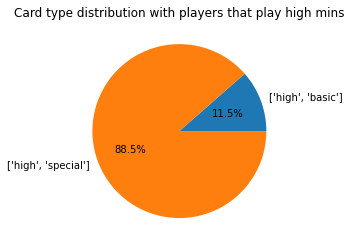

In [117]:
importlib.reload(Plot_Utils)
mins_with_label = [[mins[i]] + [ratings[i]] for i in range(len(mins))]
high_mins_only = [row for row in mins_with_label if row[0] == "high"]

values, cts = myutils.get_frequencies(high_mins_only)
Plot_Utils.create_pie_chart(cts, values, "Card type distribution with players that play high mins")

Almost all players that fall under the high minutes played category for the "MIN" attribute are **special** card types. Our classifers can use this pattern to hopefully classifer players efficiently

# **Classifier Evaluation**

We are going to run the data set through these three classifiers and analyze there accuracy and error scores to find which one is the most predictive:

1. Dummy Classifier
1. Decision Tree Classifer
1. Random Forrest Classifer

* We will run both the main data set and a smaller subset of chosen attributes with the goal of raising the accuracy score.
* For the dummy classifer, both datasets will have the same accuracy

Smaller Dataset: (WINS,MINS, PTS)

## Dummy Classification
Since the dummy classifer always predicts the label with the highest frequency, this will give us a baseline of accuracy scores that we will try to improve on

In [118]:

simple_dataset = nba_data.get_subtable(["W%", "MIN", "PTS"])

## get train / test folds (full and simple datasets)
full_train_folds, full_test_folds = myevaluation.stratified_kfold_cross_validation(nba_data.data, ratings, n_splits=10)
simple_train_folds, simple_test_folds = myevaluation.stratified_kfold_cross_validation(simple_dataset.data, ratings, n_splits=10)

## get scores
full_acc, full_err, full_pres, full_recall, full_f1, full_matrix = \
  myutils.get_scores_from_folds(nba_data.data, ratings, full_train_folds, full_test_folds, myclassifiers.MyDummyClassifier())

simple_acc, simple_err, simple_pres, simple_recall, simple_f1, simple_matrix = \
  myutils.get_scores_from_folds(simple_dataset.data, ratings, simple_train_folds, simple_test_folds, myclassifiers.MyDummyClassifier())


In [119]:
scores_table = mypytable.MyPyTable()
scores_table.column_names = ["Dataset", "Accuracy", "Error"]
scores_table.data = []
scores_table.data.append(["Full dataset", full_acc, full_err])
scores_table.data.append(["Simple dataset", simple_acc, simple_err])

print("Dummy Classification Scores")
scores_table.print_data()


Dummy Classification Scores
Dataset           Accuracy    Error
--------------  ----------  -------
Full dataset          0.56     0.44
Simple dataset        0.56     0.44


As predicted, the Dummy classifier simply picks the label that is in the dataset the most. Since the majority (56%) of the data are **basic** cards, the classifer with always classify a player as **basic**

## Decision Tree Classification
* For the decision tree classification we are going to use the smaller data set because the main dataset has a lot of attributes which creates an insanely large number of decision rules

* We are also going to run a subset that only includes the **MIN** column of the dataset to see how predictive the the minutes attribute is


In [120]:
mins_dataset = [[row] for row in mins]

## get train / test folds (full and simple datasets)
full_train_folds, full_test_folds = myevaluation.stratified_kfold_cross_validation(mins_dataset, ratings, n_splits=10)
simple_train_folds, simple_test_folds = myevaluation.stratified_kfold_cross_validation(simple_dataset.data, ratings, n_splits=10)

## get scores
full_acc, full_err, full_pres, full_recall, full_f1, full_matrix = \
  myutils.get_scores_from_folds(mins_dataset, ratings, full_train_folds, full_test_folds, myclassifiers.MyDecisionTreeClassifier(10))

simple_acc, simple_err, simple_pres, simple_recall, simple_f1, simple_matrix = \
  myutils.get_scores_from_folds(simple_dataset.data, ratings, simple_train_folds, simple_test_folds, myclassifiers.MyDecisionTreeClassifier(10))

rfc = myclassifiers.MyNaiveBayesClassifier()

In [121]:
scores_table = mypytable.MyPyTable()
scores_table.column_names = ["Dataset", "Accuracy", "Error"]
scores_table.data = []

scores_table.data.append(["Simple dataset (MINS, PTS, WIN%)", simple_acc, simple_err])
scores_table.data.append(["Minutes Only", full_acc, full_err])


print("Decision Tree Classification Scores")
scores_table.print_data()

Decision Tree Classification Scores
Dataset                             Accuracy    Error
--------------------------------  ----------  -------
Simple dataset (MINS, PTS, WIN%)        0.79     0.21
Minutes Only                            0.69     0.31


* As you can see with the accuracy scores, the Decision tree was much better than the Dummy Classifer for the simple dataset
* Running the classifier with only the minutes played attribute also raised the accuracy score by over 20% proving it is a strong predictive attribute

## Random Forest Classification

In [122]:
import mysklearn.myrandomforestclassifier as myrfc
importlib.reload(myrfc)
## get train / test folds (full and simple datasets)
simple_train_folds, simple_test_folds = myevaluation.stratified_kfold_cross_validation(simple_dataset.data, ratings, n_splits=10)


simple_acc, simple_err, simple_pres, simple_recall, simple_f1, simple_matrix = \
  myutils.get_scores_from_folds(simple_dataset.data, ratings, simple_train_folds, simple_test_folds, myrfc.MyRandomForestClassifier(50, 10, 3))
simple_acc = round(simple_acc, 1)
simple_err = round(simple_err, 1)


In [123]:
scores_table = mypytable.MyPyTable()
scores_table.column_names = ["Dataset", "Accuracy", "Error"]
scores_table.data = []

scores_table.data.append(["Simple dataset (MINS, PTS, WIN%)", simple_acc, simple_err])



print("Random Forest Classification Scores")
scores_table.print_data()

Random Forest Classification Scores
Dataset                             Accuracy    Error
--------------------------------  ----------  -------
Simple dataset (MINS, PTS, WIN%)         0.8      0.2


Since the Random Forest Classifier has the highest accuracy rating, it is our "best classifier" for our data and we will use it to predict our final instance. 

We will use Zion Williamson as our test instance (the player on the example gold card at the top) to see if Zion deserves a **special** card rather than a **basic** card that he currently has according to our Random Forest Classifier:

In [124]:
print("Zion's stats:")
print("PLAYER           AGE    MIN       W%       PTS     FG%          3PM          FT%     REB       ")
print("---------------  -----  --------  -------  ------  -----------  -----------  ------  --------------  -----------")
print("Zion Williamson  young  high  average  high    efficient  low volume   decent  high volume")

Zion's stats:
PLAYER           AGE    MIN       W%       PTS     FG%          3PM          FT%     REB       
---------------  -----  --------  -------  ------  -----------  -----------  ------  --------------  -----------
Zion Williamson  young  high  average  high    efficient  low volume   decent  high volume


In [125]:
X_sample, X_out, y_sample, y_out = myevaluation.bootstrap_sample(simple_dataset.data, ratings, n_samples=100)


rfc.fit(X_sample, y_sample)
prediction = rfc.predict([["average", "high", "high"]])

<img src="images/goldcard.png" width="200">

In [126]:
print(prediction)

['special']


According to our classifier, Zion Williamson should have a  **special** card instead of a **basic** card based on his stats